In [ ]:
# prerequisites
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image
from torch import autograd

!pip install einops
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


device(type='cuda')

In [ ]:
torch.manual_seed(42)

DOWNLOAD_PATH = '/data/mnist'

# Set the batch size
bs = 100

# Load MNIST data into training and test DataLoader instances


# Don't quite understand transforms.Compose! 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(DOWNLOAD_PATH, train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(DOWNLOAD_PATH, train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [ ]:
# build network
z_dim = 128
nlabels = 10

def generate_vector():
  #print("in generate_vector")
  return Variable(torch.randn(bs, z_dim).view(bs, z_dim, 1, 1).to(device))

print(generate_vector().size())

torch.Size([100, 128, 1, 1])


In [ ]:
# Define Generator class

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(z_dim, 256, kernel_size=6, 
                stride=1, padding=0, bias=False),
            nn.LeakyReLU(True),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 128, kernel_size=6, 
                stride=2, padding=1, bias=False),
            nn.LeakyReLU(True),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, 1, kernel_size=4, 
                stride=2, padding=1, bias=False),
            nn.LeakyReLU(True),
            # nn.BatchNorm2d(64),
            
            # nn.ConvTranspose2d(64, 32, kernel_size=4, 
            #     stride=2, padding=1, bias=False),
            # nn.LeakyReLU(True),
            # nn.BatchNorm2d(32), 

            # nn.ConvTranspose2d(
            #     32, 1, kernel_size=4, 
            #     stride=2, padding=1, bias=False),
            nn.Tanh()
        )

    
    def forward(self):
        input = generate_vector()
        return self.main(input)


In [ ]:
## Code from https://github.com/kriventsov/vit-pytorch/blob/main/vit_pytorch/vit_pytorch.py


import torch
import torch.nn.functional as F

from torch import nn
from einops import rearrange

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(x, **kwargs) + x

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn

    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, dim)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=8):
        super().__init__()
        self.heads = heads
        self.scale = dim ** -0.5

        self.to_qkv = nn.Linear(dim, dim * 3, bias=False)
        self.to_out = nn.Linear(dim, dim)

    def forward(self, x, mask = None):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x)
        q, k, v = rearrange(qkv, 'b n (qkv h d) -> qkv b h n d', qkv=3, h=h)

        dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale

        if mask is not None:
            mask = F.pad(mask.flatten(1), (1, 0), value = True)
            assert mask.shape[-1] == dots.shape[-1], 'mask has incorrect dimensions'
            mask = mask[:, None, :] * mask[:, :, None]
            dots.masked_fill_(~mask, float('-inf'))
            del mask

        attn = dots.softmax(dim=-1)

        out = torch.einsum('bhij,bhjd->bhid', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, mlp_dim):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Residual(PreNorm(dim, Attention(dim, heads = heads))),
                Residual(PreNorm(dim, FeedForward(dim, mlp_dim)))
            ]))

    def forward(self, x, mask=None):
        for attn, ff in self.layers:
            x = attn(x, mask=mask)
            x = ff(x)
        return x

class Discriminator(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, channels=3):
        super().__init__()
        assert image_size % patch_size == 0, 'image dimensions must be divisible by the patch size'
        self.num_patches = (image_size // patch_size) ** 2
        patch_dim = channels * patch_size ** 2
        self.dim = dim
        self.patch_size = patch_size

        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_patches, dim))
        self.patch_to_embedding = nn.Linear(patch_dim, dim)
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, depth, heads, mlp_dim)

        self.to_cls_token = nn.Identity()

        self.mlp_head = nn.Sequential(
            nn.Linear(dim*self.num_patches, mlp_dim),
            nn.GELU(),
            nn.Linear(mlp_dim, 1)
        )

    def forward(self, img, mask=None):

        #print("D forward:", img.size())
        p = self.patch_size
        

        x = rearrange(img, 'b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = p, p2 = p)
        #print("Rearranged:", x.size())
        x = self.patch_to_embedding(x)
        #print("Patch to Embedding:", x.size())
        #cls_tokens = self.cls_token.expand(img.shape[0], -1, -1)
        #x = torch.cat((cls_tokens, x), dim=1)
        #print("TOkenized:", x.size())
        x += self.pos_embedding
        #print("Position Embedding:", x.size())
        x = self.transformer(x, mask)
        #print("Transformed:", x.size())
        x = x.view(bs, self.dim*self.num_patches)
        #print("Transformed to MLP", x.size())
        #x = self.to_cls_token(x[:, 0])
        #print("to cls token:", x.size())
        x = self.mlp_head(x)
        #print("MLP:", x.size())
        #x = torch.flatten(x, 1)
        #print("Flattened:", x.size())
        return x ## Not a sigmoid


In [ ]:
# Uncomment to test Generator creation and forward function
# Output must be a tensor of size [bs, 100], where bs = batch size

Gtest = Generator().to(device)
print(Gtest().size())


# Uncomment to test Discriminator creation and forward function
# Output must be a tensor of size [bs, 1], where bs= batch size

mnist_dim = 28
input = torch.ones(bs, 1, 28, 28).to(device)
label = torch.ones(bs, dtype=int).to(device)
Dtest = Discriminator(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128).to(device)
print(Dtest(input).size())

torch.Size([100, 1, 28, 28])
torch.Size([100, 1])


In [ ]:
def weights_init(m):
    """
    This function initializes the model weights randomly from a 
    Normal distribution. This follows the specification from the DCGAN paper.
    https://arxiv.org/pdf/1511.06434.pdf
    Source: https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        print("Conv init")
        nn.init.normal_(m.weight.data, 0.0, 0.002)
    elif classname.find('BatchNorm') != -1:
        print("BatchNorm Init")
        nn.init.normal_(m.weight.data, 1.0, 0.002)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# build network
import math
#mnist_dim = train_dataset.data.size(1) * train_dataset.data.size(2)

G = Generator().to(device)
G.apply(weights_init)

D = Discriminator(image_size=28, patch_size=7, num_classes=10, channels=1,
            dim=64, depth=6, heads=8, mlp_dim=128).to(device)
D.apply(weights_init)

Conv init
BatchNorm Init
Conv init
BatchNorm Init
Conv init


Discriminator(
  (patch_to_embedding): Linear(in_features=49, out_features=64, bias=True)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): Residual(
          (fn): PreNorm(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (fn): Attention(
              (to_qkv): Linear(in_features=64, out_features=192, bias=False)
              (to_out): Linear(in_features=64, out_features=64, bias=True)
            )
          )
        )
        (1): Residual(
          (fn): PreNorm(
            (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
            (fn): FeedForward(
              (net): Sequential(
                (0): Linear(in_features=64, out_features=128, bias=True)
                (1): GELU(approximate=none)
                (2): Linear(in_features=128, out_features=64, bias=True)
              )
            )
          )
        )
      )
      (1): ModuleList(
        (0): Residual(
          (f

In [ ]:
def gradient_penalty(discriminator, real_imgs, fake_imgs, gamma=10):
  batch_size = real_imgs.size(0)
  epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
  epsilon = epsilon.expand_as(real_imgs)

  interpolation = epsilon * real_imgs.data + (1 - epsilon) * fake_imgs.data
  interpolation = Variable(interpolation, requires_grad=True).to(device)


  interpolation_logits = discriminator(interpolation)
  grad_outputs = torch.ones(interpolation_logits.size()).to(device)

  gradients = autograd.grad(outputs=interpolation_logits,
                            inputs=interpolation,
                            grad_outputs=grad_outputs,
                            create_graph=True,
                            retain_graph=True)[0]

  gradients = gradients.view(batch_size, -1)
  gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=1) + 1e-12)
  return torch.mean(gamma * ((gradients_norm - 1) ** 2))

In [ ]:
# loss
# optimizer
lr = 0.00005
G_optimizer = optim.RMSprop(G.parameters(), lr=lr)
D_optimizer = optim.RMSprop(D.parameters(), lr=lr)

In [ ]:
def D_train(x):

    #=======================Train the discriminator=======================#
    D.zero_grad()
    D.train()

    # Discriminator forward pass on real images

    x_real, y_real = x, torch.ones(bs, 1)
    x_real, y_real = Variable(x_real.to(device)), Variable(y_real.to(device))
    D_output_real = D(x_real).to(device)


    # Generate fake images
    x_fake = G().to(device)
    y_fake = Variable(torch.zeros(bs, 1).to(device))  
    D_output_fake = D(x_fake.view(bs, 1, 28, 28))

    # gradient backprop & optimize ONLY Discriminator parameters
    # Use Wasserstein Loss
    # Find penalty between real and fake images
    grad_penalty = gradient_penalty(D, x_real, x_fake)
    
    D_loss = torch.mean(D_output_fake) - torch.mean(D_output_real) + grad_penalty
    D_loss.backward()
    D_optimizer.step()

    # Clip parameters (only for Discriminator)

    # for p in D.parameters():
    #   p.data.clamp_(-0.01, 0.01)
      
    return  D_loss.data.item()

In [ ]:
def G_train(x):
    #=======================Train the generator=======================#
    
    G.zero_grad()
    G.train()

    # Generate fake output signal for Discriminator (all ones)
    y = Variable(torch.ones(bs, 1).to(device))

    # Generate fake images
    G_output = G().to(device)
    D_output = D(G_output.view(bs, 1, 28, 28))

    # gradient backprop & optimize ONLY Generator parameters
    # Wasserstein Loss
    G_loss = -torch.mean(D_output)
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [ ]:
n_epoch = 60
D_losses, G_losses = [], []
for epoch in range(1, n_epoch+1):           
    for batch_idx, (x, labels) in enumerate(train_loader):
        for _ in range(1):
          D_losses.append(D_train(x))
        for _ in range(1):
          G_losses.append(G_train(x))
    
    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/60]: loss_d: -22.153, loss_g: -4.092
[2/60]: loss_d: -14.195, loss_g: -1.346
[3/60]: loss_d: -10.071, loss_g: 3.586
[4/60]: loss_d: -7.834, loss_g: 5.018
[5/60]: loss_d: -6.569, loss_g: 4.712
[6/60]: loss_d: -5.841, loss_g: 3.812
[7/60]: loss_d: -5.398, loss_g: 3.008
[8/60]: loss_d: -5.120, loss_g: 2.393
[9/60]: loss_d: -4.944, loss_g: 1.963
[10/60]: loss_d: -4.839, loss_g: 1.670
[11/60]: loss_d: -4.780, loss_g: 1.445
[12/60]: loss_d: -4.754, loss_g: 1.297
[13/60]: loss_d: -4.754, loss_g: 1.200
[14/60]: loss_d: -4.769, loss_g: 1.144
[15/60]: loss_d: -4.795, loss_g: 1.121
[16/60]: loss_d: -4.832, loss_g: 1.136
[17/60]: loss_d: -4.875, loss_g: 1.173
[18/60]: loss_d: -4.922, loss_g: 1.226
[19/60]: loss_d: -4.975, loss_g: 1.289
[20/60]: loss_d: -5.029, loss_g: 1.355
[21/60]: loss_d: -5.086, loss_g: 1.439
[22/60]: loss_d: -5.144, loss_g: 1.523
[23/60]: loss_d: -5.204, loss_g: 1.600
[24/60]: loss_d: -5.266, loss_g: 1.677
[25/60]: loss_d: -5.327, loss_g: 1.754
[26/60]: loss_d: -5.391, loss

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torchvision.transforms.functional as FF


plt.rcParams["savefig.bbox"] = 'tight'


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = FF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

torch.Size([100, 1, 28, 28])


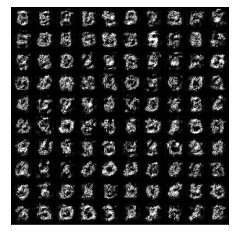

In [ ]:
from torchvision.utils import make_grid
import torch.nn.functional as F

with torch.no_grad():
    test_z = Variable(torch.randn(100, z_dim).to(device))
    generated = G()
    images = generated.view(generated.size(0), 1, 28, 28)
    print(images.size())
    #save_image(generated.view(generated.size(0), 1, 28, 28), './sample_' + '.png')
    image = make_grid(images, nrow=10)
    #print(image.size())
    show(image)